<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#Imports" data-toc-modified-id="Imports-0.1"><span class="toc-item-num">0.1&nbsp;&nbsp;</span>Imports</a></span></li></ul></li><li><span><a href="#Classes" data-toc-modified-id="Classes-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Classes</a></span><ul class="toc-item"><li><span><a href="#MonDataset" data-toc-modified-id="MonDataset-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>MonDataset</a></span></li><li><span><a href="#Autoencoder" data-toc-modified-id="Autoencoder-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Autoencoder</a></span></li></ul></li><li><span><a href="#Tester-l'auto-encodeur-sur-MNIST" data-toc-modified-id="Tester-l'auto-encodeur-sur-MNIST-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Tester l'auto-encodeur sur MNIST</a></span></li></ul></div>

## Imports

In [98]:
import torch
from datamaestro import prepare_dataset
import numpy as np
from skimage.io import imshow
from pathlib import Path
import os
from torchvision.utils import make_grid
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.tensorboard import SummaryWriter
import datetime
import torch.optim as optim
import matplotlib.pyplot as plt


# Classes

## MonDataset

On implémente une classe ``MonDataset`` avec ses deux méthodes : ``__getitem__`` et ``__len__``.

In [2]:
class MonDataset(Dataset):
    
    def __init__(self, ds):
        self.images = ds.images.data()
        self.labels = ds.labels.data()
        
    def __getitem__(self, index):
        dimensions = self.images[index].shape
        x = np.reshape(self.images[index], dimensions[0]*dimensions[1])
        x = x / 255.0
        y = self.labels[index]
        return x, y
    
    def __len__(self):
        return len(self.labels)


In [3]:
ds=prepare_dataset("com.lecun.mnist");

In [4]:
trainSet = MonDataset(ds.train)
testSet = MonDataset(ds.test)

In [88]:
trainData = DataLoader(trainSet,shuffle=True,batch_size=32)
testData = DataLoader(testSet,shuffle=True,batch_size=len(testSet))

In [92]:
testData = DataLoader(testSet,shuffle=True,batch_size=len(testSet))
for x in testData:
    print(x)

[tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]], dtype=torch.float64), tensor([4, 0, 1,  ..., 3, 8, 2], dtype=torch.uint8)]


## Autoencoder

In [95]:
class AutoEncoder(nn.Module):
    def __init__(self, in_size, weight):
        super().__init__()
        self.encoder = nn.Linear(in_size, int(in_size/6), bias=False)
        self.encoder.weight.data = weight.clone().double()

    def forward(self, x):
        encoded = F.relu(self.encoder(x))
        y_decoded = F.sigmoid(F.linear(encoded, self.encoder.weight.t()))
        return encoded, y_decoded

# Tester l'auto-encodeur sur MNIST

In [108]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = AutoEncoder(784, torch.randn(28, 784)).to(device)

optimizer = optim.Adam(model.parameters(), lr=1e-1)

criterion = nn.MSELoss()

epochs = 50

In [109]:
erreurTrain = []
erreurTest = []
for epoch in range(epochs):
    loss = 0
    for batchInput,_ in trainData:
        
        optimizer.zero_grad()
        _, output = model(batchInput.double())
        trainLoss = criterion(output, batchInput)
        trainLoss.backward()
        
        # perform parameter update based on current gradients
        optimizer.step()
        
        # add the mini-batch training loss to epoch loss
        loss += trainLoss.item()
        
    with torch.no_grad(): 
        for testInput,_ in testData:
            _, outputTest = model(testInput.double())
            testLoss = criterion(outputTest, testInput)
    
    # compute the epoch training loss
    loss = loss / len(trainData)
    
    erreurTrain.append(loss)
    erreurTest.append(testLoss)

    if epoch%10 == 0:
        print(f"epoch : {epoch}/{epochs}, loss = {loss}, test loss = {testLoss}")

epoch : 0/50, loss = 0.08222214765632811, test loss = 0.07679472112246707
epoch : 10/50, loss = 0.07214171176122741, test loss = 0.07182968971344363
epoch : 20/50, loss = 0.07178649838609089, test loss = 0.07063163725806837
epoch : 30/50, loss = 0.07078829912835699, test loss = 0.06960083002714099
epoch : 40/50, loss = 0.07005272045934784, test loss = 0.06880072816222359


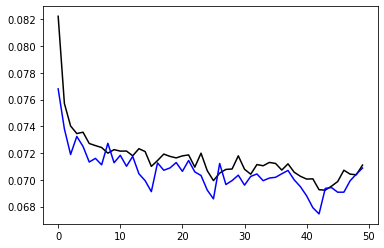

In [110]:
plt.plot(erreurTrain, 'black')
plt.plot(erreurTest, 'blue')